## Алгоритмы анализа данных.
### Урок 4. Деревья решений.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

from sklearn import model_selection

import numpy as np

#### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [373]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=42)

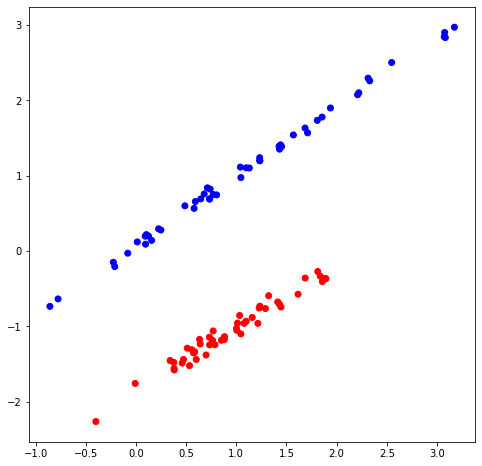

In [375]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [376]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [377]:
# Класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [378]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1    # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [379]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [380]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [381]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels, n_features, n_leafs):
    
    #  обозначим минимальное количество объектов в узле
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    if n_features > data.shape[1]:
        n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее n_leafs объектов
            if len(true_data) < n_leafs or len(false_data) < n_leafs:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [382]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, n_features, n_leafs):

    quality, t, index = find_best_split(data, labels, n_features, n_leafs)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, n_features, n_leafs)
    false_branch = build_tree(false_data, false_labels, n_features, n_leafs)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [383]:
# Проход объекта по дереву для его классификации
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [384]:
# Предсказание деревом для всего датасета
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [385]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [386]:
# Введение функции подсчета точности
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [387]:
def compare(n_features, n_leafs, train_data=train_data, test_data=test_data,
               train_labels=train_labels, test_labels=test_labels):
    tree = build_tree(train_data, train_labels, n_features, n_leafs)
    train_res = predict(train_data, tree)
    result = predict(test_data, tree)
    train_ac = accuracy_metric(train_labels, train_res)
    test_ac = accuracy_metric(test_labels, result)
    print(f'Features: {n_features}, leafs: {n_leafs}')
    print(f'Accuracy: train={train_ac:.4f}, test={test_ac:.4f}')
    return test_ac

In [388]:
best_ac = 0
feat_best = 0
leaf_best = 0

for i in range(2,5):
    for j in range(3,7):
        compare(i, j)
        if compare(i, j) > best_ac:
            best_ac = compare(i, j)
            feat_best = i
            leaf_best = j
        print('\n')
print(f'\nЛучшие критерии останова: \nКоличество признаков - {feat_best} \nМинимальное количество листьев - {leaf_best}')

Features: 2, leafs: 3
Accuracy: train=98.5714, test=96.6667
Features: 2, leafs: 3
Accuracy: train=98.5714, test=96.6667
Features: 2, leafs: 3
Accuracy: train=98.5714, test=96.6667


Features: 2, leafs: 4
Accuracy: train=98.5714, test=96.6667
Features: 2, leafs: 4
Accuracy: train=98.5714, test=96.6667


Features: 2, leafs: 5
Accuracy: train=98.5714, test=96.6667
Features: 2, leafs: 5
Accuracy: train=98.5714, test=96.6667


Features: 2, leafs: 6
Accuracy: train=98.5714, test=96.6667
Features: 2, leafs: 6
Accuracy: train=98.5714, test=96.6667


Features: 3, leafs: 3
Accuracy: train=98.5714, test=96.6667
Features: 3, leafs: 3
Accuracy: train=98.5714, test=96.6667


Features: 3, leafs: 4
Accuracy: train=98.5714, test=96.6667
Features: 3, leafs: 4
Accuracy: train=98.5714, test=96.6667


Features: 3, leafs: 5
Accuracy: train=98.5714, test=96.6667
Features: 3, leafs: 5
Accuracy: train=98.5714, test=96.6667


Features: 3, leafs: 6
Accuracy: train=98.5714, test=96.6667
Features: 3, leafs: 6
Accu

#### 2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений. В материалах также есть пример скрипта для расчета дерева - Lesson_4_script, им можно воспользоваться аналогично тому, как это было на предыдущих уроках.

In [389]:
#Изменим функцию predict в классе Leaf
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
#         # подсчет количества объектов разных классов
#         classes = {}  # сформируем словарь "класс: количество объектов"
#         for label in self.labels:
#             if label not in classes:
#                 classes[label] = 0
#             classes[label] += 1
#         #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
#         prediction = max(classes, key=classes.get)

        #вместо количества объектов в классе берем среднее количество объектов в выборке
        prediction = np.mean(self.labels)
        return prediction 
    
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

#Вместо Джини вычислим дисперию значений объектов
def disp(labels):
    return np.std(labels)


#Изменим функцию качества
def quality(left_labels, right_labels, current_dispersion):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_dispersion - p * disp(left_labels) - (1 - p) * disp(right_labels)

# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


#Изменим функцию нахождения лучшего разбиения:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_disp = disp(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_disp)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, tree_depth=1):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)


    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [390]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [391]:
train_answers = predict(train_data, my_tree)

In [392]:
test_answers = predict(test_data, my_tree)

In [393]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [394]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
test_accuracy

96.66666666666667

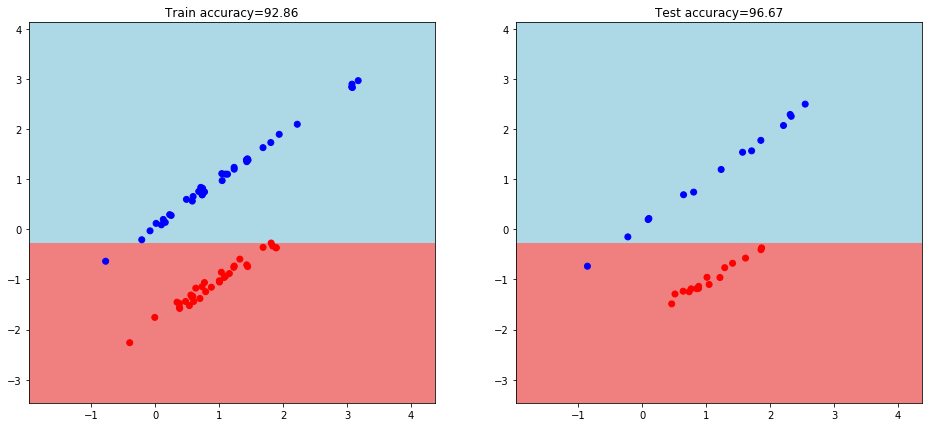

In [395]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}');